# Analysis of homophones (and minimal pairs) across real and artificial lexica

Sean Trott and Benjamin Bergen


In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word", verbose=False)
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp
           }
    

In [6]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word", n=5):
    """Loads lexicons for a given language."""
    df_real_all = pd.read_csv("data/processed/{lan1}/reals/{lan2}_all_reals_{n}phone.csv".format(lan1=language,
                                                                                         lan2=language,n=n))
    df_lemmas_mps = pd.read_csv("data/processed/{lan1}/reals/{lan2}_with_mps_{n}phone.csv".format(lan1=language,
                                                                                         lan2=language,n=n))
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction_{n}phone.csv".format(lan1=language,
                                                                                                                           lan2=language, n=n))
    return df_real_all, df_lemmas_mps, df_artificials
    

In [7]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

# Concatenating all languages together

For convenience, the code below runs the primary analyses on each language to build a summary table of the main findings.

In [8]:
languages_and_n = [('english', 5),
                  ('german', 5),
                  ('dutch', 5),
                  ('french', 4),
                  ('japanese', 4)]

In [9]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [10]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_2 = 'num_homophones'
COVARIATES_MODEL_2 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_2 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_2, regressors=' + '.join(COVARIATES_MODEL_2))

In [11]:
model1_results, model2_results = [], []
descriptive_stats = []

for language, n in languages_and_n:
    print("Loading lexica for {language}...".format(language=language))
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column, n=n)

    # Process artificial lexica
    print("Processing artificial lexica...")
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Create normed surprisal column
    df_processed['surprisal_normed'] = df_processed['surprisal'] / df_processed['num_phones']
    for p in processed_artificials:
        p['surprisal_normed'] = p['surprisal'] / p['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_processed)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    
    # Run model 2
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_2, 
                                covariates=COVARIATES_MODEL_2)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 2 data
    model2_results.append(df_analysis)

Loading lexica for english...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Loading lexica for german...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Loading lexica for dutch...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


 30%|███       | 3/10 [00:02<00:06,  1.04it/s]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Loading lexica for french...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Loading lexica for japanese...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


## Descriptive results

### Homophony

In [19]:
df_descriptive = pd.concat(descriptive_stats)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [20]:
df_descriptive['language'] = df_descriptive['language'].apply(lambda x: x[0].upper() + x[1:])

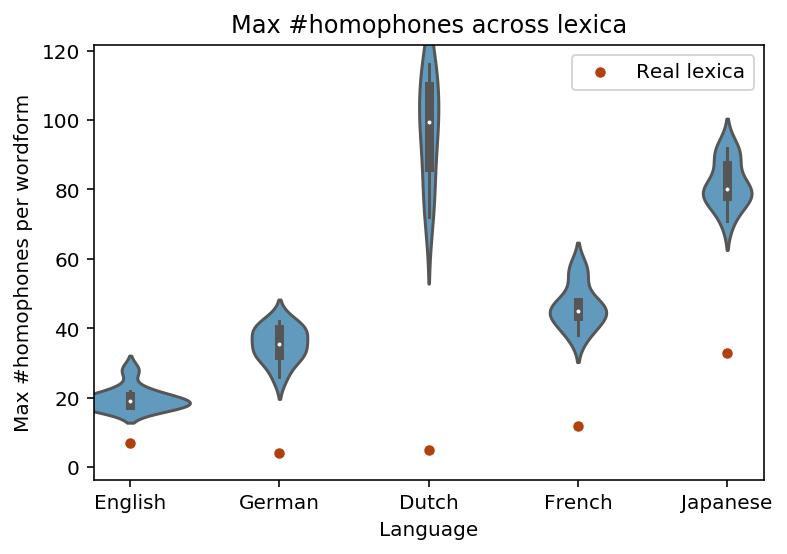

In [21]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3]
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
                   y = 'max_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Max #homophones across lexica")
plt.ylabel("Max #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_homophones.png", dpi=400, bbox_inches = "tight")

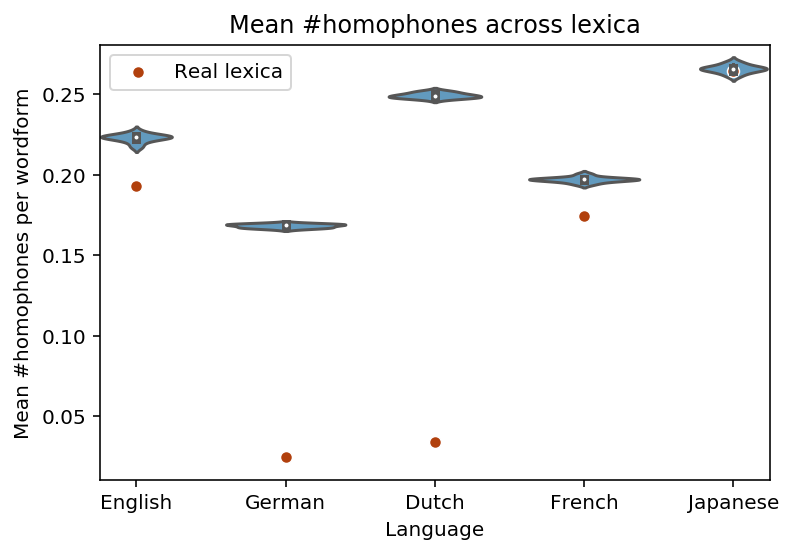

In [22]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
           y = 'mean_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Mean #homophones across lexica")
plt.ylabel("Mean #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_homophones.png", dpi=400, bbox_inches = "tight")

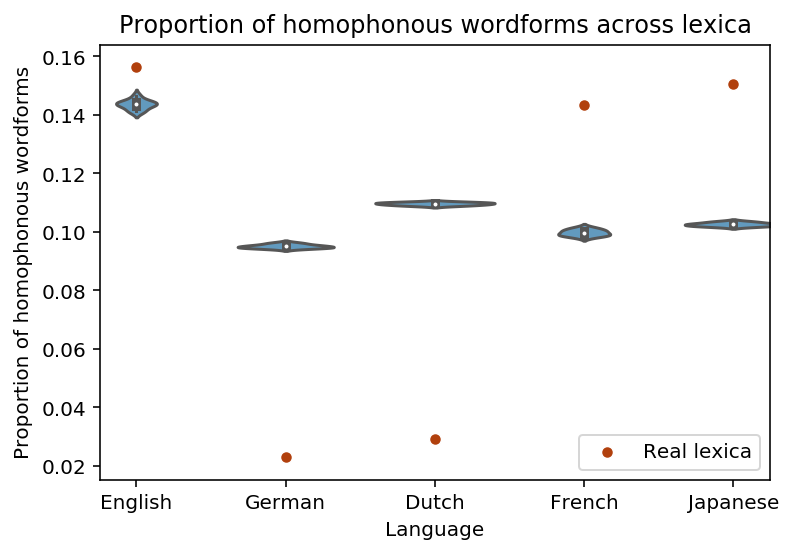

In [23]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Proportion of homophonous wordforms across lexica")
plt.ylabel("Proportion of homophonous wordforms")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/homophony_rate.png", dpi=400, bbox_inches = "tight")

### P-values

In [38]:
p_values = []
for language, _ in languages_and_n:
    df_tmp = df_descriptive[df_descriptive['language']==language]
    
    df_real = df_tmp[df_tmp['real']=="Yes"]
    df_art = df_tmp[df_tmp['real']=="No"]
    
    # Get p-value for max homophones
    real_max, art_max = df_real['max_homophones'].values[0], df_art['max_homophones'].values
    abs_centered_art_max = abs(art_max - art_max.mean())
    abs_centered_real_max = abs(real_max - art_max.mean())
    p_max = len(abs_centered_art_max[abs_centered_art_max>=abs_centered_real_max]) / len(abs_centered_art_max)

    # Get p-value for mean homophones
    real_mean, art_mean = df_real['mean_homophones'].values[0], df_art['mean_homophones'].values
    abs_centered_art_mean = abs(art_mean - art_mean.mean())
    abs_centered_real_mean = abs(real_mean - art_mean.mean())
    p_mean = len(abs_centered_art_mean[abs_centered_art_mean>=abs_centered_real_mean]) / len(abs_centered_art_mean)

    # Get p-value for proportion of homophones
    real_rate, art_rate = df_real['homophone_percentage'].values[0], df_art['homophone_percentage'].values
    abs_centered_art_rate = abs(art_rate - art_rate.mean())
    abs_centered_real_rate = abs(real_rate - art_rate.mean())
    p_rate = len(abs_centered_art_rate[abs_centered_art_rate>=abs_centered_real_rate]) / len(abs_centered_art_rate)
    
    p_values.append({
        'language': language,
        'p_max': p_max,
        'p_mean': p_mean,
        'p_rate': p_rate
    })


In [39]:
df_p = pd.DataFrame(p_values)

In [40]:
df_p

,language,p_max,p_mean,p_rate
0,english,0.0,0.0,0.0
1,german,0.0,0.0,0.0
2,dutch,0.0,0.0,0.0
3,french,0.0,0.0,0.0
4,japanese,0.0,0.5,0.0


### Descriptive tables

In [23]:
df_descriptive.groupby(["language", "real"]).max()

homophone_percentage  max_homophones  max_mp  mean_homophones  \
language real                                                                  
dutch    No                  0.1103             116      30           0.2518   
         Yes                 0.0291               5      42           0.0340   
english  No                  0.1466              28      45           0.2266   
         Yes                 0.1564               7      46           0.1931   
french   No                  0.1014              57      66           0.2002   
         Yes                 0.1434              12      63           0.1745   
german   No                  0.0963              42      24           0.1696   
         Yes                 0.0229               4      26           0.0246   
japanese No                  0.1036              92      60           0.2698   
         Yes                 0.1506              33      59           0.2645   

               mean_mp  total_mp  
language real                     
dutch    No     1.0374     56138  
         Yes    1.4981     97768  
english  No     2.3186     79330  
         Yes    2.5598     89868  
french   No     2.6822     98253  
         Yes    2.7060    100876  
german   No     0.7980     35384  
         Yes    1.0187     51378  
japanese No     3.3873    137370  
         Yes    4.7489    192090

In [24]:
df_descriptive.groupby(["language", "real"]).min()

homophone_percentage  max_homophones  max_mp  mean_homophones  \
language real                                                                  
dutch    No                  0.1089              72      25           0.2469   
         Yes                 0.0291               5      42           0.0340   
english  No                  0.1412              17      39           0.2172   
         Yes                 0.1564               7      46           0.1931   
french   No                  0.0983              38      53           0.1940   
         Yes                 0.1434              12      63           0.1745   
german   No                  0.0943              26      20           0.1664   
         Yes                 0.0229               4      26           0.0246   
japanese No                  0.1018              71      48           0.2612   
         Yes                 0.1506              33      59           0.2645   

               mean_mp  total_mp  
language real                     
dutch    No     0.9969     53828  
         Yes    1.4981     97768  
english  No     2.2257     76004  
         Yes    2.5598     89868  
french   No     2.6262     96022  
         Yes    2.7060    100876  
german   No     0.7609     33652  
         Yes    1.0187     51378  
japanese No     3.2849    132656  
         Yes    4.7489    192090

In [33]:
df_descriptive.groupby(["language", "real"]).mean()

homophone_percentage  max_homophones  max_mp  mean_homophones  \
language real                                                                  
dutch    No                 0.10966            97.1    27.3          0.24913   
         Yes                0.02910             5.0    42.0          0.03400   
english  No                 0.14359            19.8    41.9          0.22274   
         Yes                0.15640             7.0    46.0          0.19310   
french   No                 0.09978            46.3    59.7          0.19696   
         Yes                0.14340            12.0    63.0          0.17450   
german   No                 0.09514            35.4    21.6          0.16822   
         Yes                0.02290             4.0    26.0          0.02460   
japanese No                 0.10262            81.6    53.8          0.26563   
         Yes                0.15060            33.0    59.0          0.26450   

               mean_mp  total_mp  
language real                     
dutch    No    1.01865   55026.6  
         Yes   1.49810   97768.0  
english  No    2.27931   78081.8  
         Yes   2.55980   89868.0  
french   No    2.65582   97142.2  
         Yes   2.70600  100876.0  
german   No    0.78248   34642.4  
         Yes   1.01870   51378.0  
japanese No    3.32338  134306.0  
         Yes   4.74890  192090.0

In [34]:
df_descriptive.groupby(["language", "real"]).std()

homophone_percentage  max_homophones    max_mp  \
language real                                                   
dutch    No                0.000462       15.125034  1.888562   
         Yes                    NaN             NaN       NaN   
english  No                0.001610        3.293090  2.183270   
         Yes                    NaN             NaN       NaN   
french   No                0.001054        6.111010  4.854551   
         Yes                    NaN             NaN       NaN   
german   No                0.000642        4.993329  1.264911   
         Yes                    NaN             NaN       NaN   
japanese No                0.000590        6.669999  3.794733   
         Yes                    NaN             NaN       NaN   

               mean_homophones   mean_mp     total_mp  
language real                                          
dutch    No           0.001580  0.010910   600.166681  
         Yes               NaN       NaN          NaN  
english  No           0.002547  0.029703  1082.693124  
         Yes               NaN       NaN          NaN  
french   No           0.001615  0.019096   751.845256  
         Yes               NaN       NaN          NaN  
german   No           0.001140  0.011964   550.931171  
         Yes               NaN       NaN          NaN  
japanese No           0.002418  0.029503  1343.372539  
         Yes               NaN       NaN          NaN

### Minimal pairs

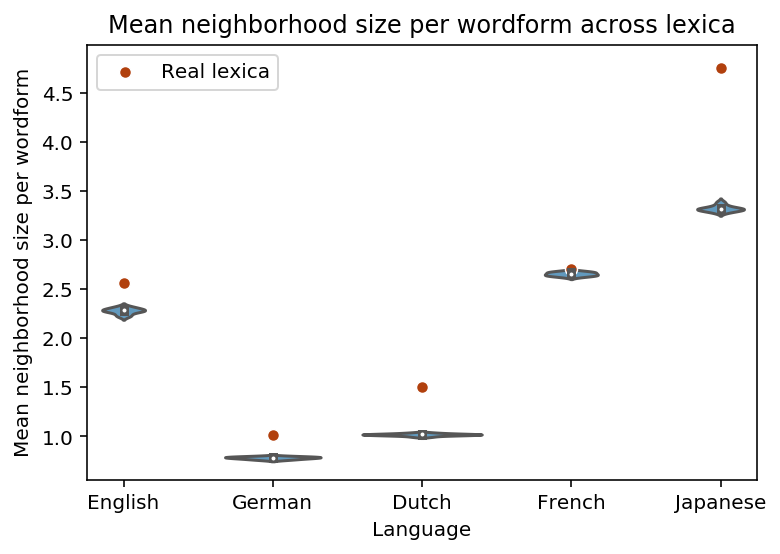

In [24]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Mean neighborhood size per wordform across lexica")
plt.ylabel("Mean neighborhood size per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

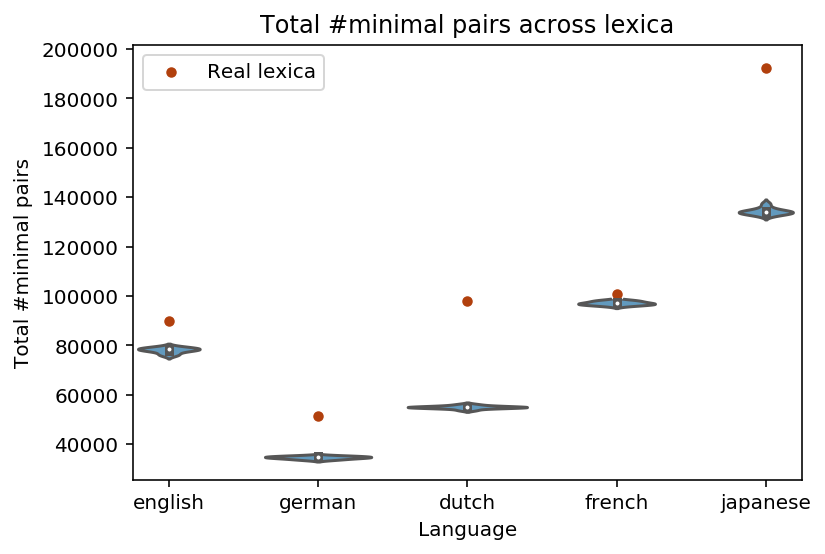

In [26]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Total #minimal pairs across lexica")
plt.ylabel("Total #minimal pairs")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

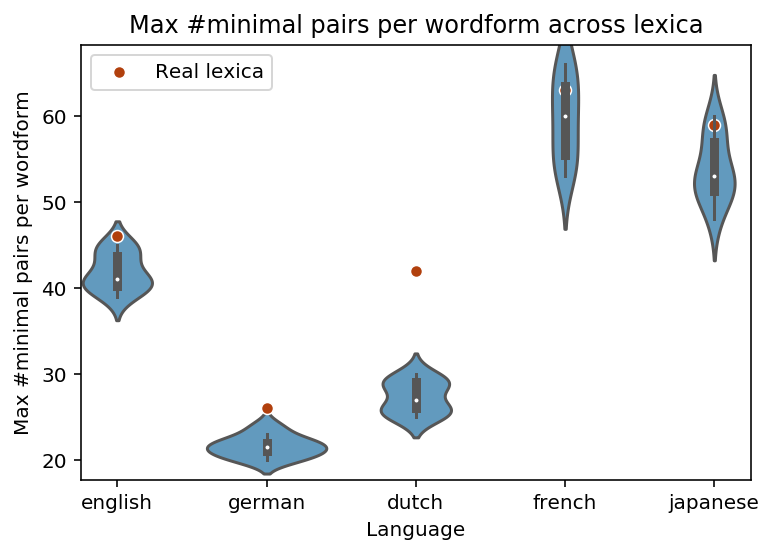

In [27]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Max #minimal pairs per wordform across lexica")
plt.ylabel("Max #minimal pairs per wordform")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/max_mps.png", dpi=400, bbox_inches = "tight")

## Modeling results

### Model 1: `#homophones ~ #syllables + surprisal`

In [25]:
df_all_model1 = pd.concat(model1_results)

In [26]:
df_all_model1['language'] = df_all_model1['language'].apply(lambda x: x[0].upper() + x[1:])

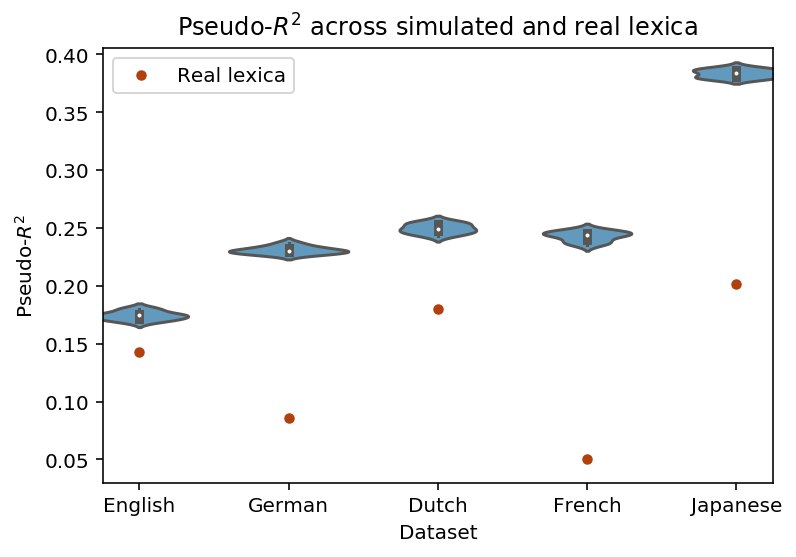

In [27]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_r2.png", dpi=400, bbox_inches = "tight")

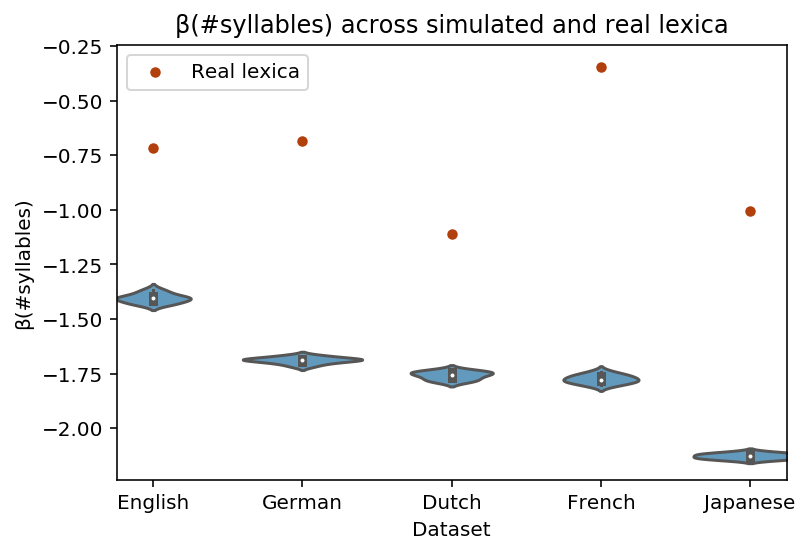

In [28]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_#sylls.png", dpi=400, bbox_inches = "tight")

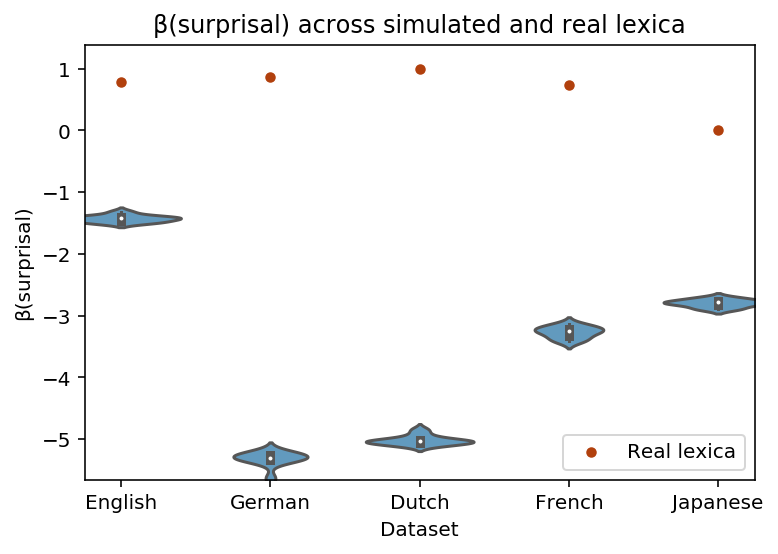

In [29]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_surprisal.png", dpi=400, bbox_inches = "tight")

### P-values

In [42]:
p_values = []
for language, _ in languages_and_n:
    df_tmp = df_all_model1[df_all_model1['language']==language]
    
    df_real = df_tmp[df_tmp['real']=="Yes"]
    df_art = df_tmp[df_tmp['real']=="No"]
    
    # Get p-value for pr^2
    real_pr2, art_pr2 = df_real['pr2'].values[0], df_art['pr2'].values
    abs_centered_art_pr2 = abs(art_pr2 - art_pr2.mean())
    abs_centered_real_pr2 = abs(real_pr2 - art_pr2.mean())
    p_pr2 = len(abs_centered_art_pr2[abs_centered_art_pr2>=abs_centered_real_pr2]) / len(abs_centered_art_pr2)

    # Get p-value for #sylls
    real_sylls, art_sylls = df_real['num_sylls_est'].values[0], df_art['num_sylls_est'].values
    abs_centered_art_sylls = abs(art_sylls - art_sylls.mean())
    abs_centered_real_sylls = abs(real_sylls - art_sylls.mean())
    p_sylls = len(abs_centered_art_pr2[abs_centered_art_sylls>=abs_centered_real_sylls]) / len(abs_centered_art_sylls)


    # Get p-value for surprisal
    real_surprisal, art_surprisal = df_real['surprisal_normed'].values[0], df_art['surprisal_normed'].values
    abs_centered_art_surprisal = abs(art_surprisal - art_surprisal.mean())
    abs_centered_real_surprisal = abs(real_surprisal - art_surprisal.mean())
    p_surprisal = len(abs_centered_art_surprisal[abs_centered_art_surprisal>=abs_centered_real_surprisal]) / len(abs_centered_art_surprisal)
    
    p_values.append({
        'language': language,
        'p_pr2': p_pr2,
        'p_sylls': p_sylls,
        'p_surprisal': p_surprisal
    })


In [43]:
df_p = pd.DataFrame(p_values)

In [44]:
df_p

,language,p_pr2,p_surprisal,p_sylls
0,english,0.0,0.0,0.0
1,german,0.0,0.0,0.0
2,dutch,0.0,0.0,0.0
3,french,0.0,0.0,0.0
4,japanese,0.0,0.0,0.0


### Stats for model 1

In [35]:
df_all_model1.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     7.175134         -5.013913      -1.758179  0.249705
         Yes   -1.721724          0.997444      -1.111901  0.180386
english  No     2.920846         -1.426311      -1.404238  0.174445
         Yes   -0.837976          0.781546      -0.717063  0.142716
french   No     6.004592         -3.265694      -1.774783  0.242995
         Yes   -1.615980          0.732816      -0.346659  0.050538
german   No     7.127010         -5.316192      -1.688568  0.230932
         Yes   -2.596171          0.860233      -0.685789  0.086204
japanese No     8.252695         -2.796497      -2.127798  0.383593
         Yes    2.026171          0.000420      -1.005391  0.201417

In [36]:
df_all_model1.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     0.095307          0.073824       0.018262  0.004155
         Yes         NaN               NaN            NaN       NaN
english  No     0.088494          0.055047       0.021050  0.003695
         Yes         NaN               NaN            NaN       NaN
french   No     0.131979          0.092115       0.019618  0.004291
         Yes         NaN               NaN            NaN       NaN
german   No     0.120348          0.120383       0.014105  0.003193
         Yes         NaN               NaN            NaN       NaN
japanese No     0.091944          0.060368       0.012093  0.003574
         Yes         NaN               NaN            NaN       NaN

## Supplementary analyses

### Rank distributions and counting #syllables

In [95]:
from collections import Counter 

def aggregate_rank_distributions(df_processed, artificial_lexica, y_column, rank_N=1000):
    """Create rank distributions of some Y for real lexicon and each mode."""
    new_col = "rank_{x}".format(x=y_column)
    df_processed[new_col] = df_processed[y_column].rank(ascending=False, method="first")

    for index, lexicon in enumerate(artificial_lexica):
        lexicon[new_col] = lexicon[y_column].rank(ascending=False, method="first")

    df_critical = df_processed[[new_col, y_column, 'mode']]
    df_critical = df_critical[df_critical[new_col]<=rank_N]

    all_df = [df_critical]

    subset = np.array([sorted(l[l[new_col]<=rank_N][y_column].values, reverse=True) for l in artificial_lexica])
    if len(subset) > 0:
        # Get the median value for each i-th rank.
        medians = np.median(subset, axis=0)
        # Put into dataframe
        df_tmp = pd.DataFrame({'mode': 'artificial', y_column: medians, new_col: list(range(rank_N))})
        all_df.append(df_tmp)

    return pd.concat(all_df)

In [48]:
df_og, df_processed, df_art = load_lexicons_for_language('english', n =5)
info_for_english = process_and_extract_artificials(df_art)

100%|██████████| 10/10 [00:06<00:00,  1.69it/s]


In [96]:
Counter(df_og['num_sylls_est'])

Counter({1: 7706,
         2: 15247,
         3: 11379,
         4: 5316,
         5: 1694,
         6: 439,
         7: 95,
         8: 10,
         10: 1})

In [61]:
processed_artificials = info_for_english['processed_dataframes']

In [73]:
df_ranks_homophones = aggregate_rank_distributions(df_processed, processed_artificials, y_column="num_homophones")
df_ranks_neighbors = aggregate_rank_distributions(df_processed, processed_artificials, y_column="neighborhood_size")

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



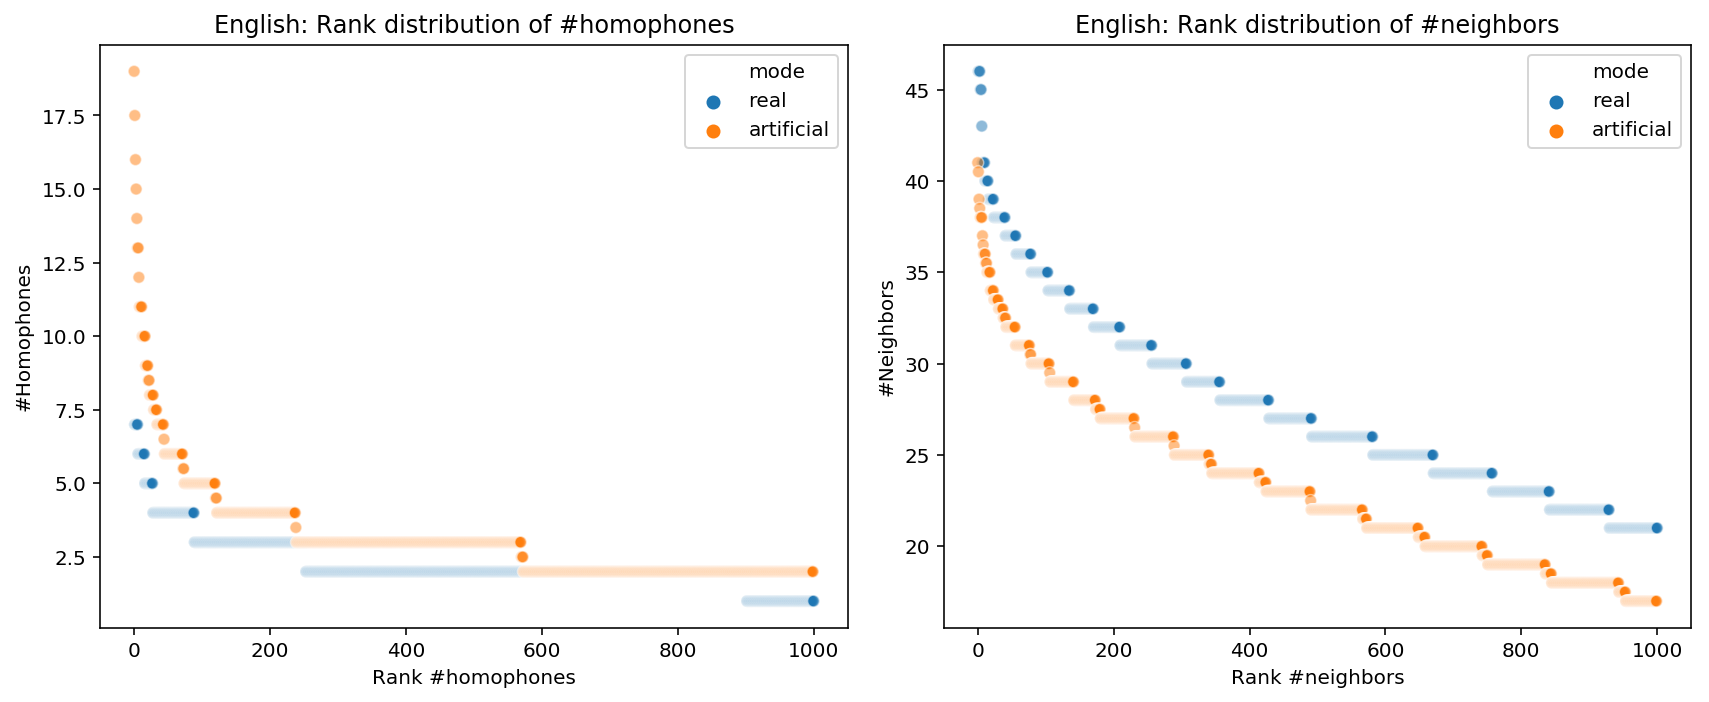

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1 = sns.scatterplot(data = df_ranks_homophones,
            x = 'rank_num_homophones',
            y = 'num_homophones',
            hue = 'mode',
            alpha =.5, ax=ax1)

ax1.set_xlabel("Rank #homophones")
ax1.set_ylabel("#Homophones")
ax1.set_title("English: Rank distribution of #homophones")

ax2 = sns.scatterplot(data = df_ranks_neighbors,
            x = 'rank_neighborhood_size',
            y = 'neighborhood_size',
            hue = 'mode',
            alpha =.5, ax=ax2)

ax2.set_xlabel("Rank #neighbors")
ax2.set_ylabel("#Neighbors")
ax2.set_title("English: Rank distribution of #neighbors")
plt.tight_layout()

plt.savefig("Figures/powerlaw/english_combined.png", dpi=300)

### Model 2: `#homophones ~ #syllables + surprisal`

In [41]:
df_all_model2 = pd.concat(model2_results)

In [42]:
df_all_model2['language'] = df_all_model2['language'].apply(lambda x: x[0].upper() + x[1:])

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


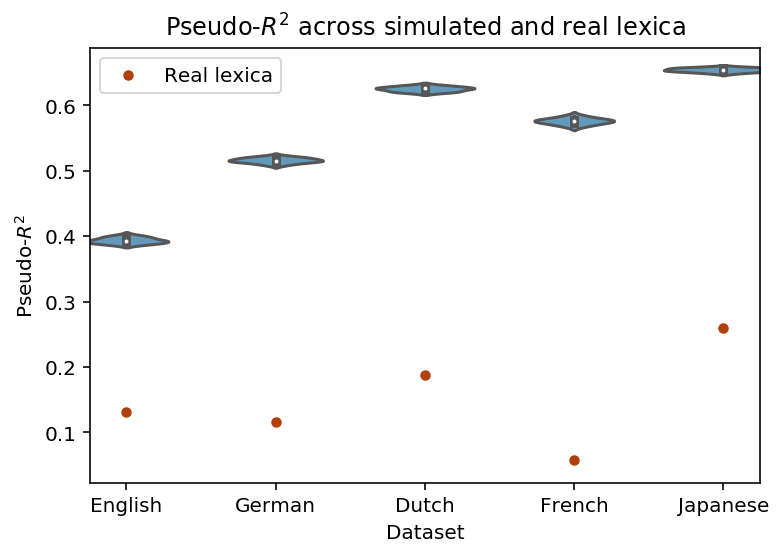

In [43]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model2_r2.png", dpi=400, bbox_inches = "tight")

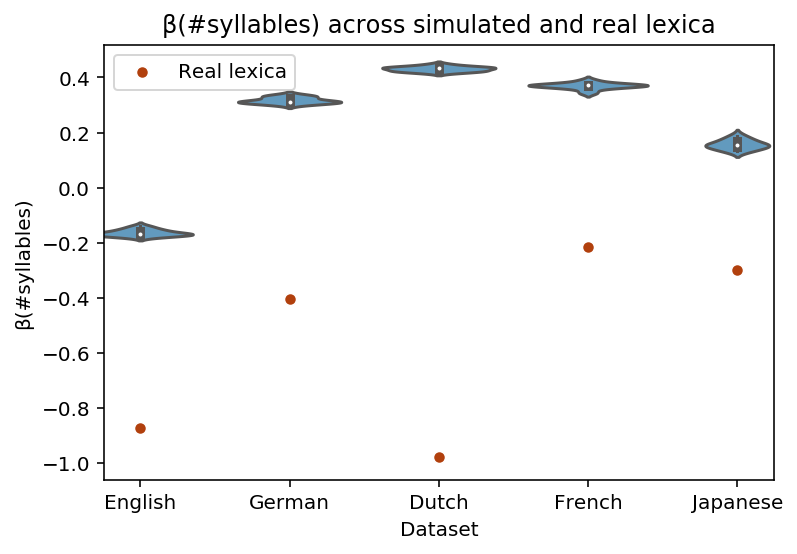

In [44]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model2_#sylls.png", dpi=400, bbox_inches = "tight")

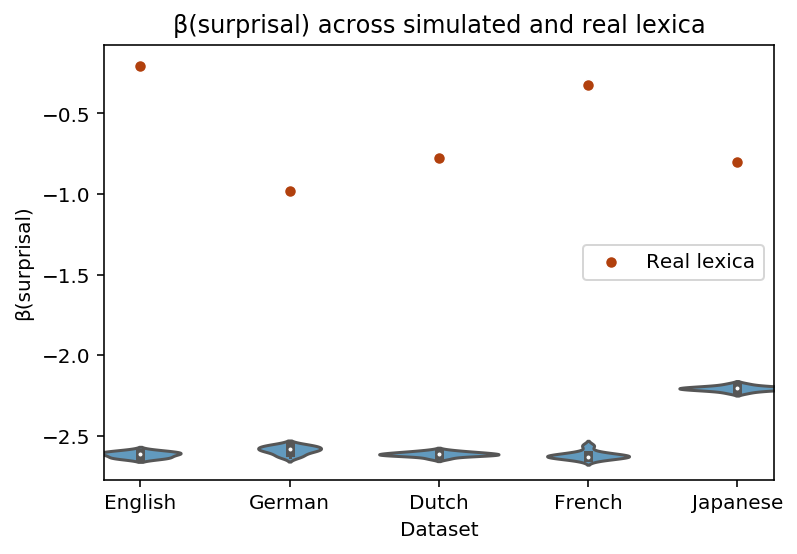

In [45]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model2_surprisal.png", dpi=400, bbox_inches = "tight")

### Stats for model 2

In [40]:
df_all_model2.groupby(["language", "real"]).mean()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
dutch    No    11.188936  -2.614512       0.431661  0.625005
         Yes    3.204029  -0.773473      -0.978526  0.187051
english  No    12.048830  -2.616651      -0.163649  0.393459
         Yes    1.308477  -0.203636      -0.871333  0.131573
french   No    11.420362  -2.552086      -0.012465  0.345745
         Yes    1.171697  -0.385968      -0.333307  0.050003
german   No    10.924749  -2.588139       0.317405  0.515890
         Yes    2.782169  -0.979246      -0.405047  0.115427
japanese No    11.388934  -2.428421      -0.106470  0.551066
         Yes    5.182131  -0.877087      -0.568710  0.237003

In [41]:
df_all_model2.groupby(["language", "real"]).std()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
dutch    No     0.058164   0.013569       0.008799  0.003506
         Yes         NaN        NaN            NaN       NaN
english  No     0.096460   0.017472       0.011407  0.004296
         Yes         NaN        NaN            NaN       NaN
french   No     0.093630   0.022121       0.010340  0.003266
         Yes         NaN        NaN            NaN       NaN
german   No     0.086856   0.024180       0.011141  0.003793
         Yes         NaN        NaN            NaN       NaN
japanese No     0.090608   0.022078       0.014450  0.005800
         Yes         NaN        NaN            NaN       NaN

# Supplementary analyses: biphone model

In [64]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp, phon_column="word", word_column="word", verbose=False)
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

## English

In [66]:
df_real = pd.read_csv("data/processed/english/english_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/english/english_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [67]:
english_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [68]:
info_for_english = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [69]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [70]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [71]:
max_m = round(np.mean(info_for_english['max_homophones']), 2)
max_std = round(np.std(info_for_english['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = english_stats['max_homophones']))

Max homophony: 
Artificial: M = 434.3, SD = 26.272
Real: 7


In [72]:
mean_m = round(np.mean(info_for_english['mean_homophones']), 2)
mean_std = round(np.std(info_for_english['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = english_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.13, SD = 0.001
Real: 0.1931


In [73]:
prop_m = round(np.mean(info_for_english['homophone_percentage']), 2)
prop_std = round(np.std(info_for_english['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = english_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.04, SD = 0.0004
Real: 0.1564


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [74]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [75]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [76]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
english  No     4.230504         -1.050552      -2.542480  0.304853
         Yes    0.264016          0.104042      -0.944182  0.130236

In [77]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
english  No      0.14839          0.108901       0.031269  0.003768
         Yes         NaN               NaN            NaN       NaN

### `num_homophones ~ #sylls + normalized_surprisal`

In [78]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [79]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [80]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
english  No     9.612628  -2.536192       1.284275  0.807300
         Yes    1.232360  -0.207295      -0.555806  0.144239

In [81]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
english  No     0.047587   0.012269       0.026304  0.003401
         Yes         NaN        NaN            NaN       NaN

## Japanese

In [82]:
df_real = pd.read_csv("data/processed/japanese/japanese_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/japanese/japanese_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/japanese/japanese_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [83]:
japanese_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [84]:
info_for_japanese = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


In [85]:
processed_artificials = info_for_japanese['processed_dataframes']

#### Norm surprisal

In [86]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [87]:
max_m = round(np.mean(info_for_japanese['max_homophones']), 2)
max_std = round(np.std(info_for_japanese['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = japanese_stats['max_homophones']))

Max homophony: 
Artificial: M = 89.6, SD = 7.902
Real: 33


In [88]:
mean_m = round(np.mean(info_for_japanese['mean_homophones']), 2)
mean_std = round(np.std(info_for_japanese['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = japanese_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.17, SD = 0.002
Real: 0.2645


In [89]:
prop_m = round(np.mean(info_for_japanese['homophone_percentage']), 2)
prop_std = round(np.std(info_for_japanese['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = japanese_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.06, SD = 0.0007
Real: 0.1506


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [90]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [91]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['japanese' for i in range(len(df_analysis))]

In [93]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
japanese No     9.577225         -3.578190      -2.432676  0.439138
         Yes    4.650302         -1.699234      -1.190803  0.220175

In [94]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
japanese No     0.169254          0.123031       0.014904  0.002325
         Yes         NaN               NaN            NaN       NaN

### `num_homophones ~ #sylls + surprisal`

In [95]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [96]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['japanese' for i in range(len(df_analysis))]

In [97]:
df_analysis.groupby(["language", "real"]).mean()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
japanese No     8.127253  -2.547732       1.415252  0.722050
         Yes    3.723139  -0.795718       0.064136  0.278735

In [98]:
df_analysis.groupby(["language", "real"]).std()

Intercept  surprisal  num_sylls_est       pr2
language real                                               
japanese No     0.033093   0.023547       0.030669  0.002845
         Yes         NaN        NaN            NaN       NaN

# Supplementary analysis: held-out surprisal

Use leave-one-out to calculate surprisal for wordforms in the real lexicon, rather than including all items in the initial language model.

In [46]:
from src.generative_model import NgramModel
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold


In [47]:
def create_model(wordforms, n=5, smoothing=.01):
    """Create n-gram model."""
    lm = NgramModel(n, wordforms, 1)
    lm.create_model(wordforms, smoothing)
    return lm

In [48]:
def calculate_heldout_surprisal(wordforms, num_folds=10):
    """Calculate surprisal using k-fold cross-validation for the real lexicon."""
    held_out_data = []

    kf = KFold(n_splits=num_folds)

    splits = list(kf.split(wordforms))

    for train_indices, test_indices in tqdm(splits):

        train = wordforms[train_indices]
        test = wordforms[test_indices]

        lm = create_model(train)

        for i in test:
            held_out_data.append({
                'word': i,
                'heldout_surprisal': -lm.evaluate(i)[-1]
            })
    
    return pd.DataFrame(held_out_data)

In [49]:
languages_and_n = [('english', 5),
                  ('german', 5),
                  ('dutch', 5),
                  ('french', 4),
                  ('japanese', 4)]

In [50]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [51]:
NUM_FOLDS = 10

In [52]:
model1_results = []
model2_results = []
descriptive_stats = []

for language, n in languages_and_n:
    print("Loading lexica for {language}...".format(language=language))
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column, n=n)
    
    # Process artificial lexica
    print("Processing artificial lexica...")
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Get heldout surprisal
    print("Calculating heldout surprisal...")
    df_real_heldout = calculate_heldout_surprisal(df_processed[phon_column].values, num_folds=NUM_FOLDS)
    df_real_heldout[phon_column] = df_real_heldout['word']
    
    # Merge with real processed lexicon
    df_merged = pd.merge(df_processed, df_real_heldout, on=phon_column)
    print(len(df_processed))
    print(len(df_merged))
    
    # Create normed surprisal column
    df_merged['surprisal_normed'] = df_merged['heldout_surprisal'] / df_merged['num_phones']
    for i in processed_artificials:
        i['surprisal_normed'] = i['surprisal'] / i['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_merged)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_merged, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    

Loading lexica for english...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 10/10 [00:23<00:00,  2.28s/it]


35107
35107
Loading lexica for german...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 10/10 [00:36<00:00,  3.71s/it]


50435
50435
Loading lexica for dutch...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


 30%|███       | 3/10 [00:04<00:11,  1.57s/it]/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)
  0%|          | 0/10 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 10/10 [00:57<00:00,  5.48s/it]


65260
65260
Loading lexica for french...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


37278
37278
Loading lexica for japanese...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing artificial lexica...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating heldout surprisal...


100%|██████████| 10/10 [00:27<00:00,  2.60s/it]


40449
40449


## Modeling results: supplementary analysis with heldout surprisal

In [53]:
df_all_model1 = pd.concat(model1_results)

In [54]:
df_all_model1['language']  = df_all_model1['language'].apply(lambda x: x[0].upper() + x[1:])

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


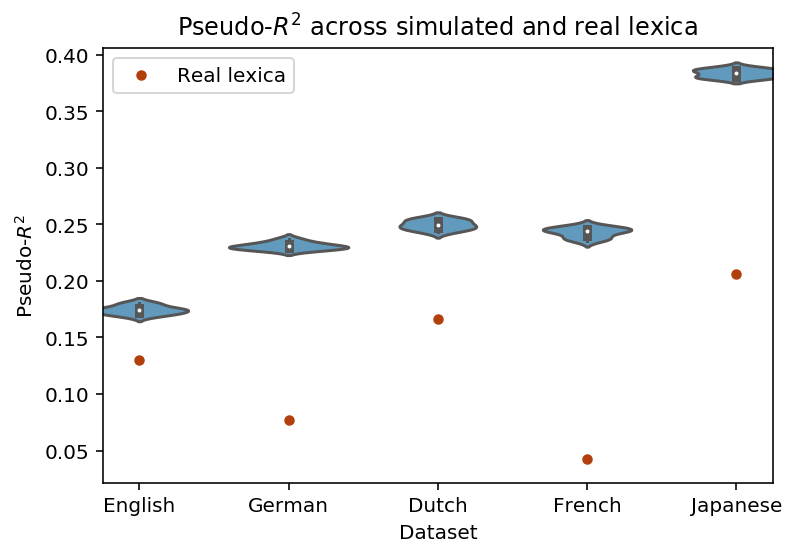

In [55]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/supplementary_model_r2.png", dpi=400, bbox_inches = "tight")

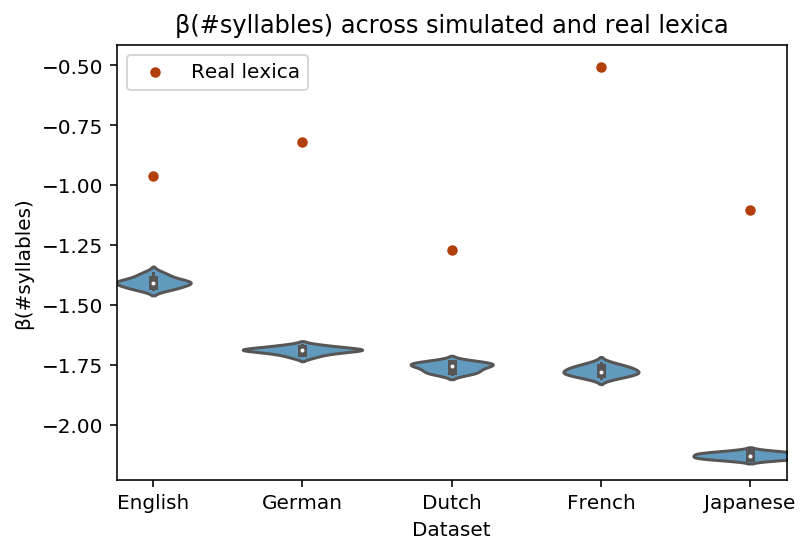

In [56]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/supplementary_model_#sylls.png", dpi=400, bbox_inches = "tight")

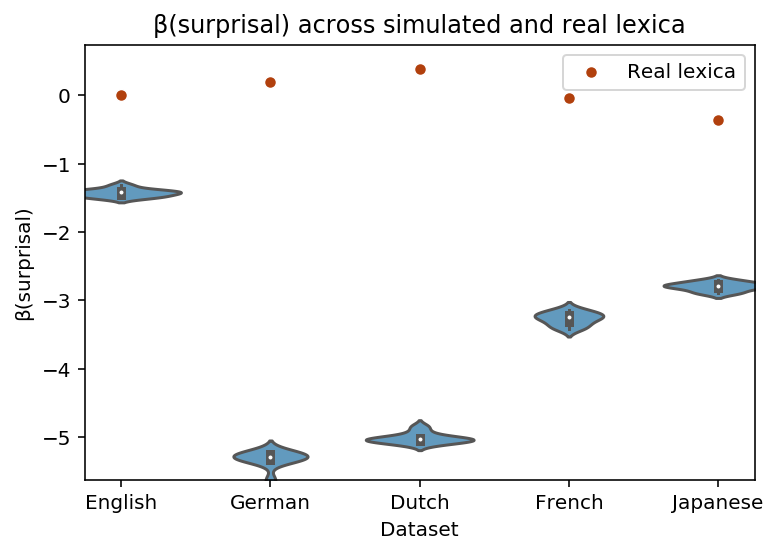

In [57]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/supplementary_model_surprisal.png", dpi=400, bbox_inches = "tight")

### Stats for model 1

In [24]:
df_all_model1.groupby(["language", "real"]).mean()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     7.175134         -5.013913      -1.758179  0.249705
         Yes   -1.216608          0.379436      -1.268686  0.165893
english  No     2.920846         -1.426311      -1.404238  0.174445
         Yes    0.442511          0.001427      -0.959942  0.130094
french   No     6.004592         -3.265694      -1.774783  0.242995
         Yes   -0.318339         -0.041732      -0.508631  0.042612
german   No     7.127010         -5.316192      -1.688568  0.230932
         Yes   -1.867311          0.196485      -0.821197  0.077112
japanese No     8.252695         -2.796497      -2.127798  0.383593
         Yes    2.859270         -0.367291      -1.103573  0.206431

In [23]:
df_all_model1.groupby(["language", "real"]).std()

Intercept  surprisal_normed  num_sylls_est       pr2
language real                                                      
dutch    No     0.095307          0.073824       0.018262  0.004155
         Yes         NaN               NaN            NaN       NaN
english  No     0.088494          0.055047       0.021050  0.003695
         Yes         NaN               NaN            NaN       NaN
french   No     0.131979          0.092115       0.019618  0.004291
         Yes         NaN               NaN            NaN       NaN
german   No     0.120348          0.120383       0.014105  0.003193
         Yes         NaN               NaN            NaN       NaN
japanese No     0.091944          0.060368       0.012093  0.003574
         Yes         NaN               NaN            NaN       NaN